## **Example of a waveform/cloud model for a vector ultralight boson**

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# Superrad

* For a given ultralight boson spin (here 1 is chosen, corresponding to a vector) 
and cloud model (described below), 
one first creates an UltralightBoson object. For some models, this requires reading in data files, etc., 
but only needs to be done once. 

In [1]:
from superrad import ultralight_boson as ub
bc = ub.UltralightBoson(spin=0, model="non-relativistic")

* a waveform model can then be constructed corresponding to specific physical parameters of the system, 
in this case an initial black hole of $M = 10^{6} M_\odot$  , dimensionless spin of 0.5 ($\chi=0.5$), and an ultralight boson mass of $1.7 \times 10^{-17}$ eV

In [3]:
wf = bc.make_waveform(10**8, 0.5, 1.7e-18, units="physical",evo_type="matched")

* this can be used to determine various properties of the black hole-boson cloud system that arises through the superradiant instability. For example:

In [4]:
print(wf.cloud_growth_time())# Cloud growth time in seconds
print(wf.mass_cloud(0)) #Cloud mass at saturation in solar mass
print(wf.spin_bh_final()) #Final black hole spin 
print(wf.gw_time())#*tunit)#characteristic timescale of GW emission (Mcloud/P_{GW}) at saturation.
print(wf.efold_time())

4.113305393066536e+44
379409.1642340869
0.4735645913272231
6.610335672393842e+41
1.998278343824131e+42


In [36]:
import healpy
import h5py

orbit_file_name='/local/home/dd274198/Documents/lisaenv/keplerian-orbits-1-0-2.h5'
with h5py.File(orbit_file_name, 'r') as fi:
    orbit_t0 = fi.attrs['t0']
    duration=fi.attrs['tduration']
    #print(fi.attrs.keys())
    print(duration)
    print(orbit_t0)
    
Tobs=3.0e7
dt=25
N=int(Tobs/dt)
t = orbit_t0 + np.arange(0,1.2*Tobs,dt)
print(N)

31536000.0
0.0
1200000


* It can also be used to calculate the resulting gravitational wave signal as a function of time.

In [7]:
dObs=0.8
sec_hour = 3600.0
sec_day=sec_hour*24
sec_year=sec_day*365
t_freq = np.arange(0,10**9*sec_year,10**2*sec_year)
print(len(t))
print(len(t_freq))
thetaObs = np.pi/4 #Observing angle w.r.t. spin axis
phi=wf.phase_gw(t)
hp,hx,delta = wf.strain_amp(t_freq,thetaObs,dObs)
hp0_f,hx0_f,delta=wf.strain_amp(t,thetaObs,dObs)
hp_f,hx_f=hp0_f*np.cos(phi),hx0_f*np.sin(phi)
fgw = wf.freq_gw(t_freq)

1440000
10000000


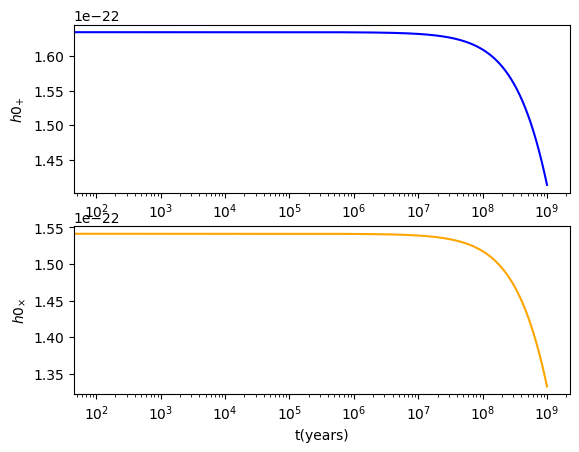

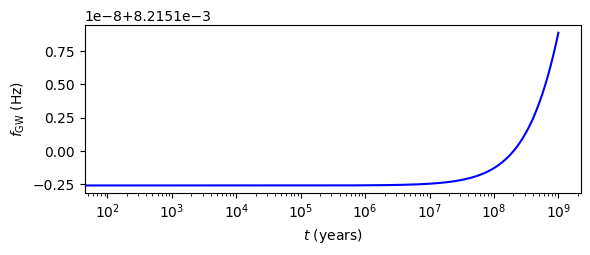

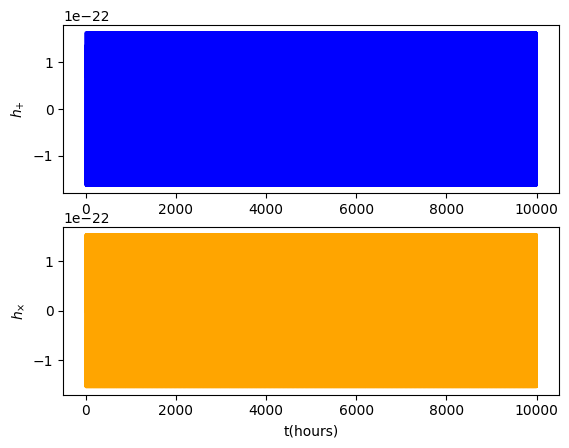

In [12]:
plt.figure(1)


plt.subplot(211)
plt.semilogx(t_freq/sec_year, np.abs(hp), color='blue', label='hp')
plt.ylabel(r"$h0_{+}$")
plt.subplot(212)
plt.semilogx(t_freq/sec_year, np.abs(hx), color='orange', label='hx')
plt.ylabel(r"$h0_{\times}$")
plt.xlabel('t(years)')
plt.show()

plt.figure(2)
plt.subplot(211)
plt.semilogx((t_freq/sec_year),fgw, color='blue')#*tunit
plt.ylabel(r"$f_{\rm GW}$ (Hz)")
plt.xlabel(r"$t$ (years)")
#plt.xlim([0,10**9])
plt.show()

plt.figure(3)
plt.subplot(211)
plt.plot(t/sec_hour, (hp0_f*np.cos(phi)), color='blue', label='hp')
plt.ylabel(r"$h_{+}$")
plt.subplot(212)
plt.plot(t/sec_hour, (hx0_f*np.sin(phi)), color='orange', label='hx')
plt.ylabel(r"$h_{\times}$")
plt.xlabel('t(hours)')
plt.show()


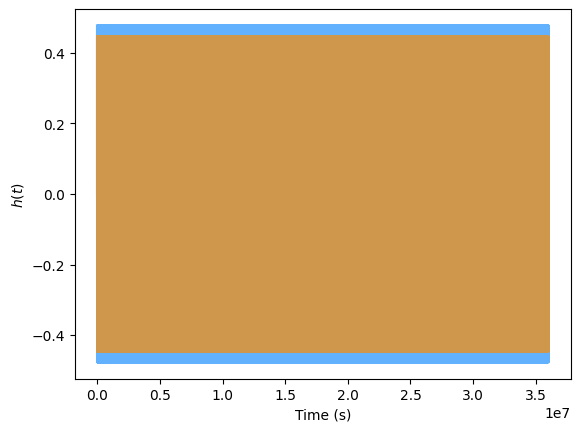

In [21]:
import gwaxion
bhb = gwaxion.BlackHoleBoson.from_parameters(m_bh=10**6, alpha=0.128, chi_bh=0.5)
cloud = bhb.best_cloud()
hp, hc = cloud.gw().hp, cloud.gw().hc
inclination = np.pi/4
plt.plot(t, hp(inclination, 0, t), label=r'$+$', color='dodgerblue', lw=2, alpha=0.7)
plt.plot(t, hc(inclination, 0, t), label=r'$\times$', color='darkorange', lw=2, alpha=0.7)
plt.xlabel("Time (s)");
plt.ylabel(r"$h(t)$");

In [22]:
#Fonction periodogramme

(0.001, 0.02)

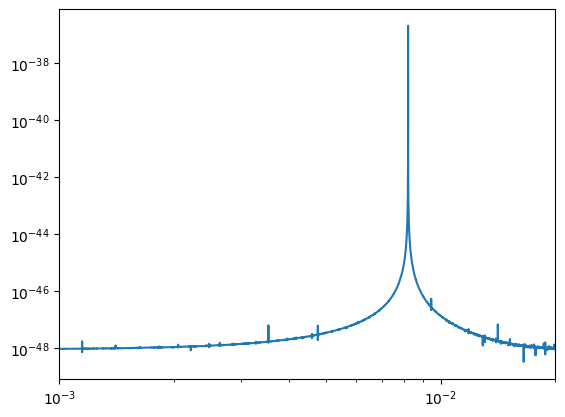

In [43]:
N_pad=len(t)-N
def Pd_num(x,dt):
    #window=np.hanning(len(x))
    #N_w=np.sum(window**2)
    N_w=len(x)
    return dt*2/N_w*(np.abs(np.fft.rfft(x)))**2

f= np.fft.rfftfreq(int(N+N_pad),d=dt)
#plt.loglog(f,Pd_num(hp(inclination, 0, t),dt),label='hp')
plt.loglog(f,Pd_num(hp_f,dt),label='hp_f')
plt.xlim([1e-3,2e-2])

# GW_Response

In [37]:
from lisagwresponse import ReadStrain

rs=ReadStrain(t,hp_f,hx_f,strain_interp_order=5,orbits=orbit_file_name, 
             orbit_interp_order=2, dt=dt, size=N,gw_beta=np.pi / 2, gw_lambda=0,t0=orbit_t0+10)

[1.0000000e+01 3.5000000e+01 6.0000000e+01 ... 2.9999935e+07 2.9999960e+07
 2.9999985e+07]
1200000


/local/home/dd274198/Documents/lisaenv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


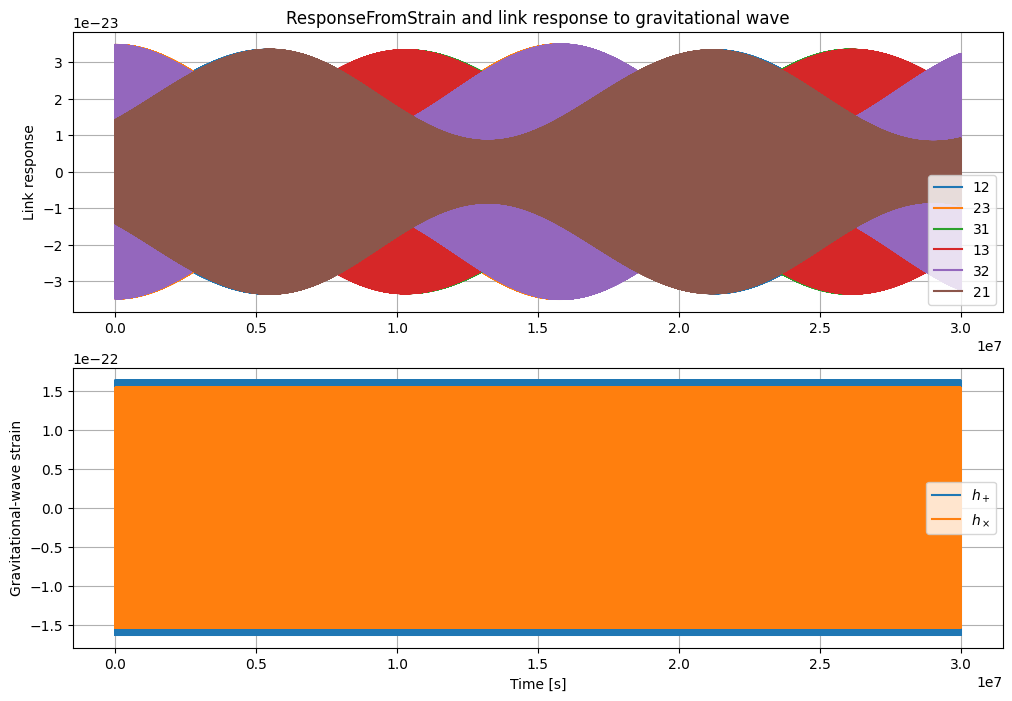

In [31]:
#SC = [1, 2, 3]
print(rs.t)
print(len(rs.t))
LINKS = [12, 23, 31, 13, 32, 21]
#response_all = rs.compute_gw_response(rs.t,LINKS)
#response_12 = rs.compute_gw_response( t+orbit_t0+10,[12])[0]
#response_23 = rs.compute_gw_response( t+orbit_t0+10,[23])[0]
#response_31 = rs.compute_gw_response( t+orbit_t0+10,[31])[0]
#response_13 = rs.compute_gw_response( t+orbit_t0+10,[13])[0]
#response_32 = rs.compute_gw_response( t+orbit_t0+10,[32])[0]
#response_21 = rs.compute_gw_response( t+orbit_t0+10,[21])[0]
rs.plot(rs.t) # show plot


In [39]:
response=rs.compute_gw_response(rs.t,LINKS)
#plt.plot(rs.t+orbit_t0+10,response_bis) # show plot
rs.write('gwresponse_file_verifosc.h5')

(0.001, 0.03)

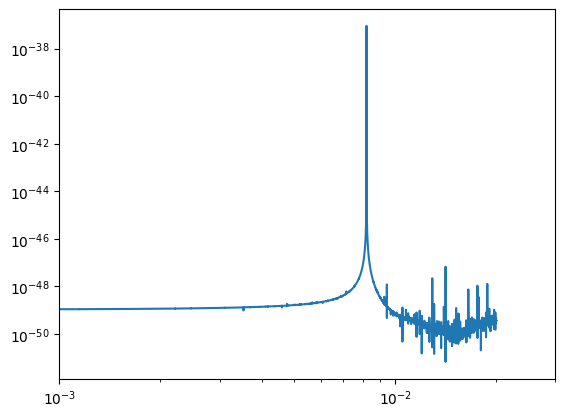

In [45]:
import pytdi
import pytdi.michelson
from pytdi.michelson import X2
from pytdi import Data

strain_file='gwresponse_file_verifosc.h5'
data = Data.from_gws(strain_file, orbit_file_name)
built_gw_X2 = X2.build(**data.args)
tab_X2gw_d=built_gw_X2(data.measurements)

f= np.fft.rfftfreq(int(N),d=dt)
plt.loglog(f,Pd_num(tab_X2gw_d,dt),label='hp_f')
plt.xlim([1e-3,3e-2])

(0.001, 0.02)

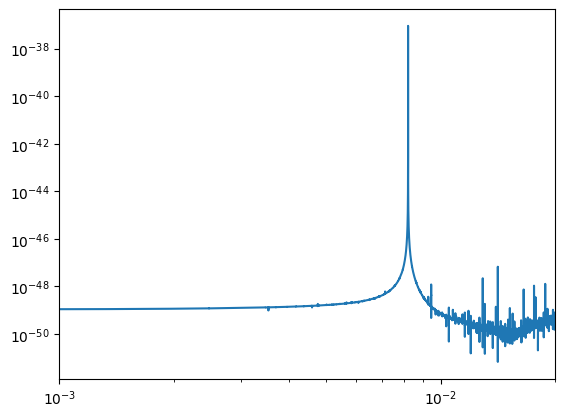

In [46]:
f= np.fft.rfftfreq(int(N),d=dt)
plt.loglog(f,Pd_num(tab_X2gw_d,dt),label='hp_f')
plt.xlim([1e-3,2e-2])